In [10]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA

In [2]:
director = np.load("features_countvec/train_countvec_features_director_name.npy")
actor1 = np.load("features_countvec/train_countvec_features_actor_1_name.npy")
actor2 = np.load("features_countvec/train_countvec_features_actor_2_name.npy")

director_test = np.load("features_countvec/test_countvec_features_director_name.npy")
actor1_test = np.load("features_countvec/test_countvec_features_actor_1_name.npy")
actor2_test = np.load("features_countvec/test_countvec_features_actor_2_name.npy")

df = pd.read_csv("train_dataset.csv")
test = pd.read_csv("test_dataset.csv")

labels = df['imdb_score_binned']

In [3]:
def preproc(df):
    df.average_degree_centrality = pd.qcut(df.average_degree_centrality, 5, labels=[0,1,2,3,4])

    # Fix the genre column

    genres = df['genres'].str.split("|")
    genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

    for x in genres:
        df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

    df.drop(["genres"], axis=1, inplace=True)

    # One hot encode language, country, content_rating
    df = pd.get_dummies(df, columns=["language", "country", "content_rating"], dtype=float)

    ids = df.id
    df = df.iloc[:,2:].select_dtypes(['number'])

    return([df, ids])

In [4]:
df.drop(columns=['imdb_score_binned', 'director_name', 'actor_1_name', 'actor_2_name'], axis=1, inplace=True)
test.drop(columns=['director_name', 'actor_1_name', 'actor_2_name'], axis=1, inplace=True)
Data, ids_train = preproc(df)
Test, ids_test = preproc(test)

In [5]:
# ensure the one hot encoded columns are all the same and in the same order

train_cols = Data.columns
test_cols = Test.columns
missing_levels = train_cols.difference(test_cols)

for x in missing_levels:
    Test[x] = 0
Test = Test[Data.columns]

In [6]:
Test = pd.concat([Test, pd.DataFrame(director_test)], axis=1)
Test = pd.concat([Test, pd.DataFrame(actor1_test)], axis=1)
Test = pd.concat([Test, pd.DataFrame(actor2_test)], axis=1)

Data = pd.concat([Data, pd.DataFrame(director)], axis=1)
Data = pd.concat([Data, pd.DataFrame(actor1)], axis=1)
Data = pd.concat([Data, pd.DataFrame(actor2)], axis=1)

Data.columns = Data.columns.astype(str)
Test.columns = Test.columns.astype(str)

In [7]:
Data_copy = Data.copy() # Make a copy to recall the column names after scaling.

Data_scaler = preprocessing.StandardScaler() # create scaler
Data_scaler.fit(Data) #fit scaler
Data = Data_scaler.fit_transform(Data)
Data_df = pd.DataFrame(Data, columns = Data_copy.columns)

Test = Data_scaler.fit_transform(Test)
Test_df = pd.DataFrame(Test, columns = Data_copy.columns)

In [8]:
# Calculate the sparsity of the dataset
num_zeros = (Data == 0).sum()
total_elements = Data.shape[0] * Data.shape[1]
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset before removal {sparsity}")

# Apply PCA to the dataset
pca = PCA(n_components=10)
data_pca = pca.fit_transform(Data)
# Calculate the sparsity of the reduced dataset
num_zeros = (data_pca == 0).sum()
total_elements = data_pca.shape[0] * data_pca.shape[1]
sparsity = num_zeros / total_elements

print(f"Sparsity after PCA: {sparsity}")

The sparsity of the dataset before removal 0.10381150381150381
Sparsity after PCA: 0.0


In [11]:
perf_metric = "accuracy" 
criterion = ["gini", "entropy"]

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

In [12]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF.fit(data_pca, labels);

In [ ]:
print(f"Best parameters: {gs_RF.best_params_}")
print(f"Best score: {gs_RF.best_score_}")

Best parameters: {'n_estimators': 500, 'max_depth': 17, 'criterion': 'gini'}
Best score: 0.7373736365317062


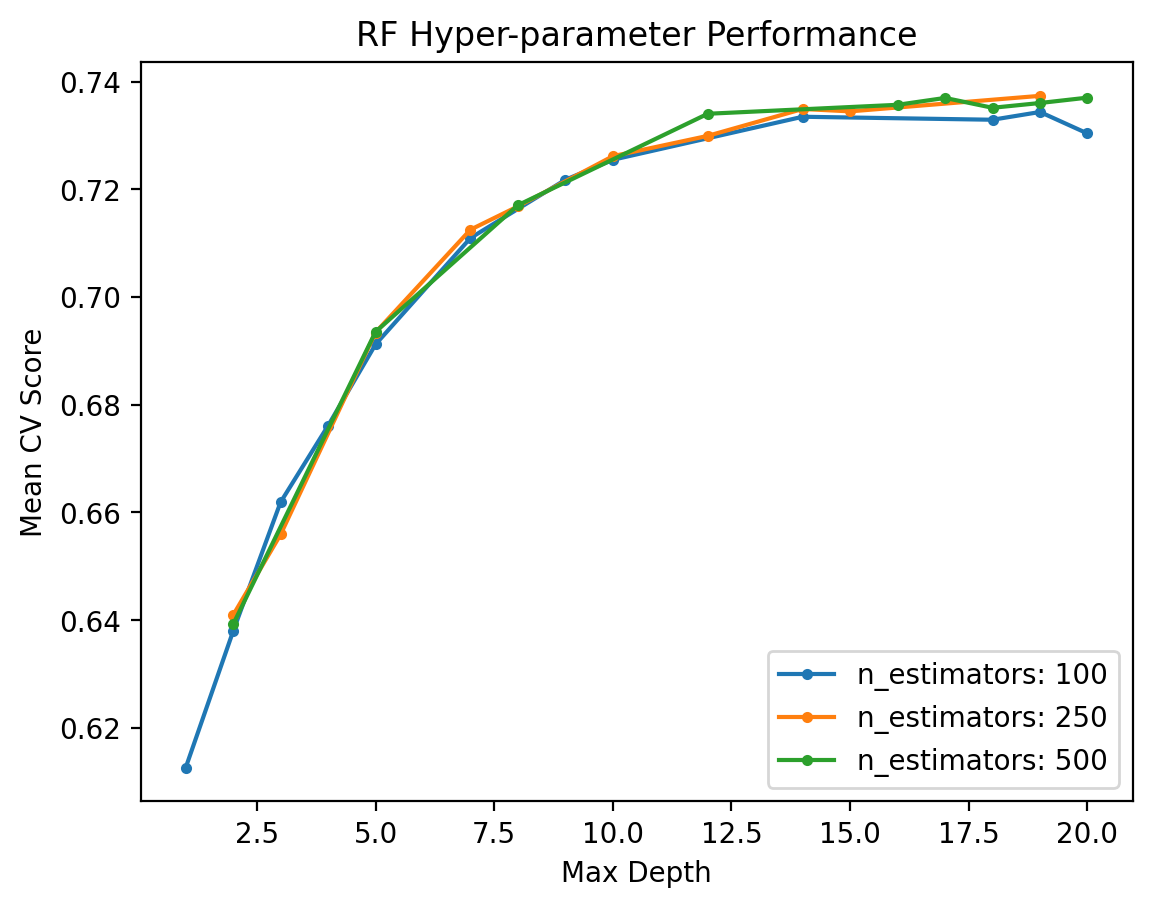

In [ ]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']

for i in results_RF['n_estimators'].unique():
    perf = results_RF[results_RF['n_estimators'] == i]
    perf_average = perf.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(perf_average, marker = '.', label = 'n_estimators: ' + str(i))
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("RF Hyper-parameter Performance")
plt.show()

# like before the graph indicates we don't need to search through higher parameters.
# the number of estimators didn't make a huge difference, the 500 and 250 curves are quite similar, 100 estimators 
# has a big jump then behaves like the other curves.

In [ ]:
test_pred = gs_RF.predict(D_test_fs)

In [ ]:
RF_kaggle = pd.DataFrame({'id':ids_test, 'imdb_score_binned': test_pred})
RF_kaggle.to_csv("results_RF.csv", index=False)